In [380]:
import numpy as np
import pandas as pd 
import netCDF4
from netCDF4 import Dataset
import geopandas as gpd

import sklearn
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.tree import export_graphviz
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import nbimporter
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Conv1D, Conv2D,Dense, Dropout, Input, Concatenate, MaxPooling1D, BatchNormalization
import tensorflow.keras

from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Concatenate
from keras.callbacks import ModelCheckpoint
import h5py
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd 
import netCDF4
from netCDF4 import Dataset
import geopandas as gpd
import sklearn
import warnings
warnings.filterwarnings("ignore")
import nbimporter
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.layers import Conv1D,Dense, Dropout, Input
import tensorflow.keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Flatten
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Concatenate
from keras.callbacks import ModelCheckpoint
import h5py
from keras.models import load_model
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
import json
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
import matplotlib.pyplot as plt
# import shap


cultures = {}
with open('lexique_cultures.json') as file:
    cultures = json.load(file)

In [381]:
%run -i geoprocessing.py
rand_state=np.random.randint(50)

<Figure size 640x480 with 0 Axes>

In [382]:
path_departments ='Geojson_files/contour-des-departements.geojson'
French_departments = gpd.read_file(path_departments)
regions_names,geometries,code_list=geojson_extract(French_departments,np.arange(len(French_departments)),'nom','geometry','code')
geojson_columns= {'Region Name': regions_names, 'Geometry':geometries,'code':code_list}
Regions=gpd.GeoDataFrame(geojson_columns)
regs_to_remove=['Paris','Haute-Corse','Corse-du-Sud']

Regions, reg_names, code_list = remove_regions(Regions,regs_to_remove)
reg_names = replace_substring(reg_names)

### Retrieving processed data 

In [406]:
#ignore
nb_years_tot=23
data_matrix_load = np.loadtxt("data_matrix_departments_2000_2022_abs_scaled.txt")
print(data_matrix_load.shape)

data_features=['u10',  't2m',  'tp']
# data_features=['u10', 'v10', 't2m', 'evabs', 'evatc', 'evavt','src', 'stl1', 'sp', 'e', 'tp', 'swvl1']

Nb_examples = len(Regions) * nb_years_tot
data_matrix_init= data_matrix_load.reshape(
    data_matrix_load.shape[0], len(data_features),365 )

data_matrix_init= data_matrix_init.transpose(0, 2, 1)

(2139, 1095)


In [407]:
#ignore
data_matrix_load = np.loadtxt("data_matrix_departments_2000_2022_abs_unscaled.txt")
print(data_matrix_load.shape)
data_features=['u10', 't2m', 'tp']
Nb_examples = len(Regions) * nb_years_tot
data_matrix_unscaled= data_matrix_load.reshape(
    data_matrix_load.shape[0], len(data_features),365 )
data_matrix_unscaled=data_matrix_unscaled.reshape((data_matrix_load.shape[0],len(data_features),365))

data_matrix_unscaled = data_matrix_unscaled.transpose(0, 2, 1)


(2139, 1095)


In [408]:
# regs_max=np.loadtxt("max_variables_regions_2000_2022.txt")
# regs_min=np.loadtxt("min_variables_regions_2000_2022.txt")

In [409]:
def unscaler(scaled_value,data_features,data_feature_idx,regs_min,regs_max):
    
    for reg in reg_filt:

    # Define the initial range of the data
        min_original = reg_mins[reg*len(data_features)+data_feature_idx]  # Minimum value of the original range
        max_original = reg_maxs[reg*len(data_features)+data_feature_idx]  # Maximum value of the original range        
        
        unscaled_value = scaled_value * (max_original - min_original) + min_original

    return unscaled_value
def heatmap_analysis(heatmap,crit_value):
    
    over50_idx=np.where(heatmap.T>crit_value)[0]
    
    return over50_idx

def is_leap_year(year):
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def get_date(year, day_of_year):
    if is_leap_year(year):
        days_in_year = 366
    else:
        days_in_year = 365

    if day_of_year < 1 or day_of_year > days_in_year:
        raise ValueError("Invalid day of the year. Must be between 1 and 366 for a leap year or 365 for a non-leap year.")

    start_date = datetime(year, 1, 1)
    target_date = start_date + timedelta(days=day_of_year - 1)
    return target_date.day, target_date.month, target_date.year
def find_bands(array, critical_value,mode):
    bands = []
    band_sizes = []
    band_start = None
    band_end = None

    for i, value in enumerate(array):
        if mode=='sup':
            if value >=critical_value :
                if band_start is None:
                    band_start = i
                    band_end = i
                else:
                    band_end = i
            else:
                if band_start is not None:
                    band_size = band_end - band_start + 1
                    bands.append((band_start, band_end))
                    band_sizes.append(band_size)
                    band_start = None
                    band_end = None
        if mode=='inf':
            if value <= critical_value :
                if band_start is None:
                    band_start = i
                    band_end = i
                else:
                    band_end = i
            else:
                if band_start is not None:
                    band_size = band_end - band_start + 1
                    bands.append((band_start, band_end))
                    band_sizes.append(band_size)
                    band_start = None
                    band_end = None

    if band_start is not None:
        band_size = band_end - band_start + 1
        bands.append((band_start, band_end))
        band_sizes.append(band_size)

    return band_sizes, bands


# Partie choix paramètres

In [618]:
# Choix de la culture :

nb_experiments=1

culture_num=99


year_choice=2022
# [2021,2022]

test_score=False
data_test_size=0.1

#This will give us a score for test_size  if True

# Mettre False rendra les évaluations déterministes i.e même données d'entraînement, même données de test (utiles pour test de score avec d'autres paramètres), 
# Mettre True rendra les évaluations non déterministes

random = True

# [True,False]


feature_choice=[0,2,10]
data_features=['u10', 'v10', 't2m', 'evabs', 'evatc', 'evavt','src', 'stl1', 'sp', 'e', 'tp', 'swvl1']

# data_matrix_init=data_matrix_unscaled
# feature_choice=[0,1,2]
# data_features=['u10', 't2m', 'tp']



#Nombre d'itérations d'entraînement
nb_epochs=30
# [20 to 35]

#Départ de l'enregistrement de loss minimal trouvé
start_loss_checkpoint=15
# [8 to 15 ]


# Paramètres de l'optimiseur
optimizer_centering=False
#True,False
Verbose=1

# portions=np.arange(0.1,2.3,0.1)
# portion=np.round(np.mean(x_min_region),2)+0.1

In [619]:
import json
cultures = {}
with open('lexique_cultures.json') as file:
    cultures = json.load(file)
culture_name=cultures[str(culture_num)]
culture_name


'Mas doux'

In [620]:
## Getting predictions and probabilities of loss of production

In [696]:

#Données production, année début / année fin
year_start=2000
year_finish=2020

#Ensemble des années représentées en données de production
years_data=np.arange(year_start,year_finish+1,1)
#Lecture du fichier excel de production d'une culture

    
rendement = pd.read_excel('Production data/cultures_2000_2020/rendement/culture_'+str(culture_num)+'Rendement'+'.xlsx')


#Removing column name
reg_rep=np.delete(np.asarray(rendement.columns),0)

x_max_region,x_min_region,std_xmax,std_xmin,val_olymp_region,olymp_abs,mean_regions=gen_std_prod(years_data,rendement,reg_rep)

reg_filt = find_indices(code_list, reg_rep)


  
portions_min=np.round(np.mean(x_min_region),2)
portions_max=np.round(np.mean(x_max_region),2)
# portion=np.round(np.mean(x_min_region),2)
# portion=1.0
portion=portions_max

# portions=np.arange(min(x_min_region)+std_xmin,max(x_min_region)-std_xmax)
# portions=np.arange(portions_min,portions_max,0.05)

In [720]:
year_data_start=2000
drop_out_rate=0.1
outlayer_neurons=128

loss_histories=[]

year_pick=int(year_choice-year_data_start)
pick_years=[year_pick]
for reg in range(1,len(reg_filt)):
    pick_years.append(year_pick+len(years_data)*reg)

tf.keras.optimizers.RMSprop(
    learning_rate=0.0002,
    centered=optimizer_centering,
    use_ema=False,
    name="RMSprop",
)
f1=[]


if random == True:
    rand_state=np.random.randint(50)
    
#Construction et définition du réseau de neurones 
labels=gen_labels_portion_4(years_data,rendement,reg_rep,portion)
data_matrix=region_year_filter(reg_filt,years_data,nb_years_tot,data_matrix_init,24,[0,1,2])

# data_matrix=region_year_filter(reg_filt,years_data,nb_years_tot,data_matrix_init,24,feature_choice)

if year_pick<len(years_data):

    data_matrix=np.delete(data_matrix,pick_years,axis=0)
    labels=np.delete(labels,pick_years,axis=0)

nb_regions=len(Regions) 



model = Sequential([

      layers.Conv1D(365, 3, padding='same', activation='relu', input_shape=(365,len(feature_choice)),name='first_conv_layer'),
      layers.MaxPooling1D(pool_size=1),
      layers.Dropout(drop_out_rate),
      layers.Conv1D(128,2, padding='same', activation='relu',name='second_conv_layer'),
      layers.MaxPooling1D(pool_size=1),
      layers.Dropout(drop_out_rate),
      layers.Conv1D(64, 1, padding='same', activation='relu',name='last_conv_layer'),
      layers.MaxPooling1D(pool_size=1),
      layers.Dropout(drop_out_rate),
      layers.Flatten(),
      layers.Dense(outlayer_neurons, activation='relu',name='last_dense_layer'),
      layers.Dense(2,activation='softmax')

])

# model = Sequential([

#       layers.Conv1D(365, 3, padding='same', activation='relu', input_shape=(365,len(feature_choice)),name='first_conv_layer'),
#       layers.MaxPooling1D(pool_size=1),
#       layers.Dropout(drop_out_rate),
#       layers.Conv1D(160,2, padding='same', activation='relu',name='second_conv_layer'),
#       layers.MaxPooling1D(pool_size=1),
#       layers.Dropout(drop_out_rate),
#       layers.Conv1D(80, 1, padding='same', activation='relu',name='first_last_conv_layer'),
#       layers.MaxPooling1D(pool_size=1),
#       layers.Conv1D(25, 1, padding='same', activation='relu',name='last_conv_layer'),
#       layers.MaxPooling1D(pool_size=1),
#       layers.Dropout(drop_out_rate),
#       layers.Flatten(),
#       layers.Dense(outlayer_neurons, activation='relu'),
#       layers.Dense(2,activation='softmax',name='last_dense_layer')

# ])


# model = Sequential([

#       layers.Conv1D(365, 3, padding='same', activation='relu', input_shape=(365,len(feature_choice)),name='first_conv_layer'),
#       layers.MaxPooling1D(pool_size=1),
#       layers.Dropout(drop_out_rate),
#       layers.Conv1D(365, 2, padding='same', activation='relu', input_shape=(365,len(feature_choice)),name='second_conv_layer'),
#       layers.MaxPooling1D(pool_size=1),

#       layers.Conv1D(160,2, padding='same', activation='relu',name='last_conv_layer'),
#       layers.MaxPooling1D(pool_size=1),
#       layers.Dropout(drop_out_rate),
#       layers.Flatten(),
#       layers.Dense(outlayer_neurons, activation='relu'),
#       layers.Dense(2,activation='softmax')

# ])


#Compilation du modèle
model.compile(optimizer='RMSProp',loss='CosineSimilarity',metrics='binary_accuracy' )

# x_train, x_test, y_train, y_test = train_test_split(data_matrix,to_categorical(labels), test_size=0.01,random_state=rand_state,shuffle=False)
x_train, x_test, y_train, y_test = train_test_split(data_matrix,to_categorical(labels), test_size=0.01,random_state=rand_state,shuffle=True)


mc = ModelCheckpoint('Test_weights/'+str(culture_num)+'_best_model_'+str(portion*100)+'.h5', monitor='val_loss', mode='min', verbose=0,save_best_only=True,start_from_epoch=start_loss_checkpoint)

history=model.fit(x_train, y_train,
                    epochs=nb_epochs,
                    batch_size=4,verbose=Verbose,class_weight=weights(labels,'binary'),validation_split=0.25,callbacks=[mc])



Epoch 1/30
66/66 [==============================] - 3s 29ms/step - loss: -0.5918 - binary_accuracy: 0.8371 - val_loss: -0.7018 - val_binary_accuracy: 0.0674
Epoch 2/30
66/66 [==============================] - 2s 25ms/step - loss: -0.6319 - binary_accuracy: 0.7841 - val_loss: -0.7708 - val_binary_accuracy: 0.9326
Epoch 3/30
66/66 [==============================] - 2s 24ms/step - loss: -0.6432 - binary_accuracy: 0.8258 - val_loss: -0.7009 - val_binary_accuracy: 0.0674
Epoch 4/30
66/66 [==============================] - 2s 25ms/step - loss: -0.6761 - binary_accuracy: 0.6136 - val_loss: -0.7645 - val_binary_accuracy: 0.9326
Epoch 5/30
66/66 [==============================] - 2s 26ms/step - loss: -0.6766 - binary_accuracy: 0.6894 - val_loss: -0.9349 - val_binary_accuracy: 0.9326
Epoch 6/30
66/66 [==============================] - 2s 25ms/step - loss: -0.6334 - binary_accuracy: 0.9242 - val_loss: -0.8555 - val_binary_accuracy: 0.9326
Epoch 7/30
66/66 [==============================] - 2s 25m

1/1 [==============================] - 0s 113ms/step
Probabilité classes : [[0.03149908 0.968501  ]]
 
Somme des gradients pour : u10 -1.4431678
Somme des gradients pour : t2m 0.67496055
Somme des gradients pour : tp -0.46889853
Somme totale des gradients pour :  -1.2371058
 
Band Sizes: [1, 3, 1, 1, 2, 3, 1, 2, 1, 2, 2, 2, 2, 2, 3, 2, 1]
Nombre de bandes pour la classe sup: 17
 Somme des bandes:  31
 
Band Sizes: [3, 1, 3, 2, 2, 1, 2, 3, 1, 1, 2, 1, 1, 3, 2, 3, 2, 1, 2, 2, 1, 3]
Nombre de bandes pour la classe sup: 22
 Somme des bandes:  42


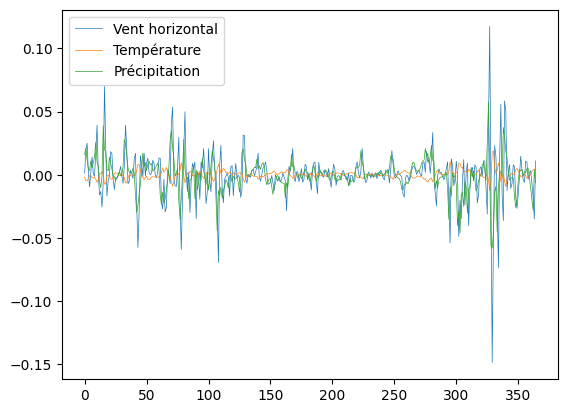

In [721]:
from tensorflow.keras.models import load_model,Model
%matplotlib inline
# Choose a sample from your dataset
sample_idx = 10
sample = x_train[sample_idx]
# print(model.predict(sample.T))
# Preprocess the sample to match the model's input shape and dtype
# You might need to adjust this based on your actual data preprocessing
sample = np.expand_dims(sample, axis=0)  # Add batch dimension if needed
sample = sample.astype(np.float32)  # Convert dtype to float32
# last_dense_layer = model.get_layer('last_dense_layer')

print('Probabilité classes :',model.predict(sample))
print(' ')
# Get the Conv1D layer you want to target for visualization
target_layer = model.get_layer('last_conv_layer')  # Replace with the correct layer name

# Create a new model that outputs the feature maps of the target layer
feature_map_model = Model(inputs=model.input, outputs=target_layer.output)
sample_tensor = tf.convert_to_tensor(sample)  # Convert the sample to a TensorFlow tensor

# Calculate gradients of output with respect to model inputs
target_class_index = 0  # Replace with the target class index you're interested in
with tf.GradientTape() as tape:
    tape.watch(sample_tensor)
    predictions = model(sample_tensor)
    target_output = predictions[:, target_class_index]
grads = tape.gradient(target_output, sample_tensor)

print('Somme des gradients pour : ' + str(data_features[0]),np.sum(feature_weights[:,0]))
print('Somme des gradients pour : ' + str(data_features[2]),np.sum(feature_weights[:,1]))
print('Somme des gradients pour : ' + str(data_features[10]),np.sum(feature_weights[:,2]))
print('Somme totale des gradients pour : ' ,np.sum(feature_weights[:,0])+np.sum(feature_weights[:,1])+np.sum(feature_weights[:,2]))
print(' ')
# Example usage

data = feature_weights[:,0]

crit = np.std(data)
band_sizes, bands = find_bands(data, crit, 'sup')
print("Band Sizes:", band_sizes)
print('Nombre de bandes pour la classe sup:',len(band_sizes))
print(' Somme des bandes: ',np.sum(band_sizes) )
print(' ')
# print("Bands (Start Index, End Index):", bands)
crit = -np.std(data)
band_sizes, bands = find_bands(data, crit, 'inf')
print("Band Sizes:", band_sizes)
print('Nombre de bandes pour la classe sup:',len(band_sizes))
print(' Somme des bandes: ',np.sum(band_sizes) )
# print("Bands (Start Index, End Index):", bands)
# Calculate feature weights for each feature within each time step
feature_weights = np.mean(grads, axis=0)

plt.plot(np.arange(len(feature_weights)),feature_weights[:,0],label='Vent horizontal',linewidth=0.5) 
plt.plot(np.arange(len(feature_weights)),feature_weights[:,1],label='Température',linewidth=0.5) 
plt.plot(np.arange(len(feature_weights)),feature_weights[:,2],label='Précipitation',linewidth=0.5) 
plt.legend()


In [722]:

# Example usage

data = feature_weights[:,0]
crit = 0.04
band_sizes, bands = find_bands(data, crit, 'sup')
print("Band Sizes:", band_sizes)
print(len(band_sizes))
print("Bands (Start Index, End Index):", bands)
crit = -0.04
band_sizes, bands = find_bands(data, crit, 'inf')
print("Band Sizes:", band_sizes)
print(len(band_sizes))
print("Bands (Start Index, End Index):", bands)

Band Sizes: [1, 2, 1, 1, 1, 2]
6
Bands (Start Index, End Index): [(16, 16), (70, 71), (81, 81), (327, 327), (336, 336), (339, 340)]
Band Sizes: [1, 1, 1, 1, 1, 1, 2, 1]
8
Bands (Start Index, End Index): [(43, 43), (78, 78), (108, 108), (295, 295), (302, 302), (310, 310), (329, 330), (334, 334)]


In [700]:
from tensorflow.keras.models import load_model,Model




feature_prod_map=np.zeros((len(reg_filt)*nb_years_tot,len(feature_choice)))
not_feature_prod_map=np.zeros((len(reg_filt)*nb_years_tot,len(feature_choice)))
grad_wind=[]
grad_total=[]
grad_temp=[]
grad_precip=[]
class_prob=[]
import matplotlib.pyplot as plt 
%matplotlib widget

# feature_choice=[0,]
culture_times=[]
# year_choice=2018
years_tot=np.arange(2000,2023,1)
iter_=0
for year_choice in years_tot:
    # for i in range(len(reg_filt)):

    data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,[0,1,2])
    # data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,feature_choice)

    year_pick=int(year_choice-year_data_start)
    data_matrix3=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_unscaled,24,[0,1,2])
    
   

    pick_years=[year_pick]
    for reg in range(1,len(reg_filt)):
        pick_years.append(year_pick+nb_years_tot*reg)

    test_year_data=data_matrix2[pick_years]
    test_year_data2=data_matrix3[pick_years]
    # for ref
    for i in range(len(reg_filt)):
    # for year_choice in years_tot:

        idx_reg=reg_filt[i]
        # print(reg_names[reg_filt[i]])
        # print(reg_rep[i])
        # Prepare your test data and convert it to the required format
        test_data = test_year_data[i] # Replace with your actual test data
        test_data2 = test_year_data2[i]
        
        # Reshape the test data to match the model's input shape (if necessary)
        test_data = np.expand_dims(test_data, axis=0)  # Uncomment if the model expects a single example
        test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)  # Convert to TensorFlow tensor



        # Get the Conv1D layer you want to target for visualization
        target_layer = model.get_layer('last_conv_layer')  # Replace with the correct layer name
        last_dense_layer = model.get_layer('last_dense_layer')
        # Create a new model that outputs the feature maps of the target layer
        feature_map_model = Model(inputs=model.input, outputs=target_layer.output)
        class_pred_model = Model(inputs=model.input, outputs=target_layer.output)
        sample_tensor = tf.convert_to_tensor(test_data)  # Convert the sample to a TensorFlow tensor

        # Calculate gradients of output with respect to model inputs
        target_class_index = 1  # Replace with the target class index you're interested in
        with tf.GradientTape() as tape:
            tape.watch(sample_tensor)
            predictions = model(sample_tensor)
            target_output = predictions[:, target_class_index]
        grads = tape.gradient(target_output, sample_tensor)

        # print('Somme des gradients pour : ' + str(data_features[0]),np.sum(feature_weights[:,0]))
        # print('Somme des gradients pour : ' + str(data_features[2]),np.sum(feature_weights[:,1]))
        # print('Somme des gradients pour : ' + str(data_features[10]),np.sum(feature_weights[:,2]))
        # print('Somme totale des gradients pour : ' ,np.sum(feature_weights[:,0])+np.sum(feature_weights[:,1])+np.sum(feature_weights[:,2]))

        # Calculate feature weights for each feature within each time step

        feature_weights = np.mean(grads, axis=0)
        
        for feature in range(len(feature_choice)):
            # features_get.append(test_data2[:,feature][np.where(feature_weights[feature]>0.000001)[0]])
            feature_prod_map[iter_][feature]=np.mean(test_data2[:,feature][np.where(feature_weights[:,feature]>np.std(feature_weights[:,feature])**2)[0]])
            not_feature_prod_map[iter_][feature]=np.mean(test_data2[:,feature][np.where(feature_weights[:,feature]<-np.std(feature_weights[:,feature])**2)[0]])
            
        grad_wind.append(np.sum(feature_weights[:,0]))
        grad_temp.append(np.sum(feature_weights[:,1]))
        grad_precip.append(np.sum(feature_weights[:,2]))
        grad_total.append(np.sum(feature_weights[:,0])+np.sum(feature_weights[:,1])+np.sum(feature_weights[:,2]))

        class_prob.append(model.predict(sample_tensor)[0])
        iter_+=1
    # plt.plot(feature_weights[:,0],label='Vent horizontal',linewidth=0.5) 
    # plt.plot(feature_weights[:,1],label='Température',linewidth=0.5) 
    # plt.plot(feature_weights[:,2],label='Précipitation',linewidth=0.5) 
    # plt.legend()


1/1 [==============================] - 0s 29ms/step


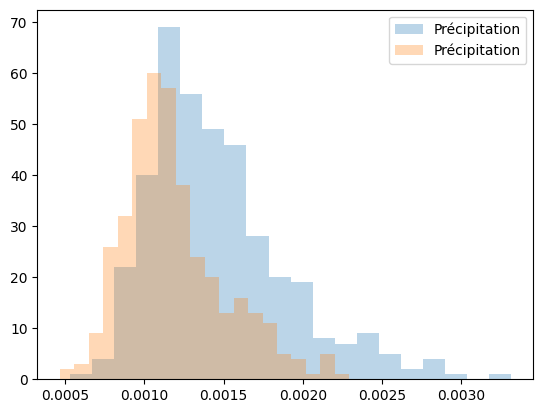

In [701]:
%matplotlib inline
# plt.hist(np.asarray(feature_prod_map)[:,0],bins=20,label='Vent horizontal',alpha=0.3) 
# plt.hist(np.asarray(feature_prod_map)[:,1],bins=20,label='Température',alpha=0.4) 
plt.hist(np.asarray(feature_prod_map)[:,2],bins=20,label='Précipitation',alpha=0.3) 
plt.hist(np.asarray(not_feature_prod_map)[:,2],bins=20,label='Précipitation',alpha=0.3) 
# plt.legend()
plt.legend()

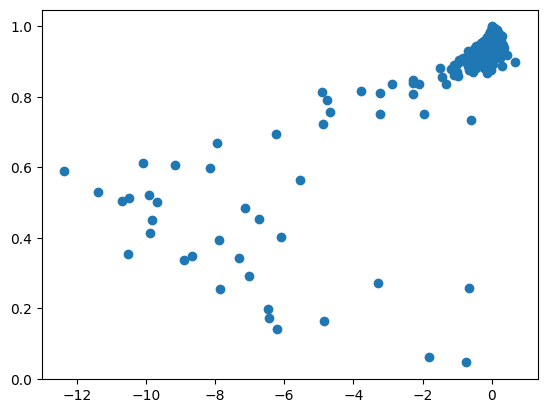

In [702]:
%matplotlib inline
plt.scatter(grad_wind,np.asarray(class_prob)[:,1])
# plt.scatter(grad_total,np.asarray(class_prob)[:,1])
plt.show()
# plt.plot(class_prob[:,1],grad_temp)

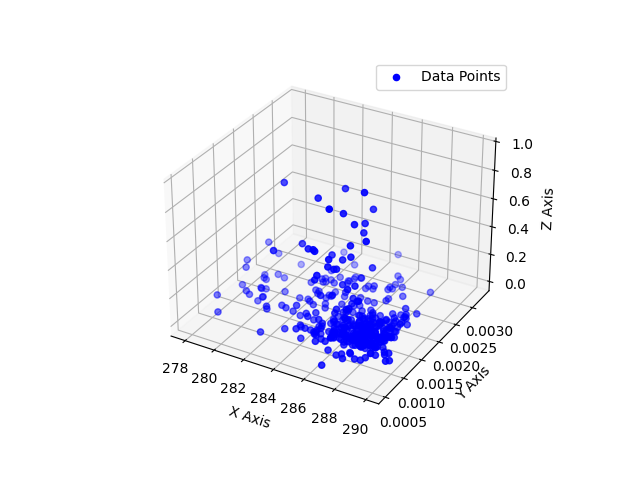

In [703]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.scatter( np.asarray(feature_prod_map)[:,1], np.asarray(feature_prod_map)[:,2],np.asarray(class_prob)[:,0], c='b', marker='o', label='Data Points')

# Plot the curves
# ax.plot(x, y, z, label='Curve 1', color='r')
# ax.plot(curve_x, curve_y2, curve_z, label='Curve 2', color='g')

# Set labels and legend
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.legend()

# Show the plot
plt.show()

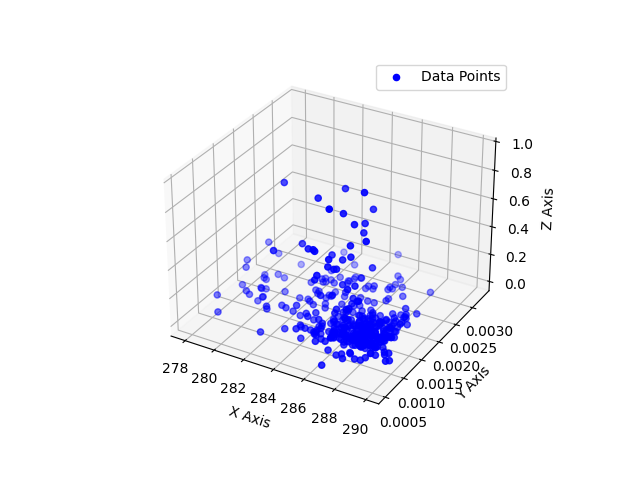

In [704]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.scatter( np.asarray(feature_prod_map)[:,1], np.asarray(feature_prod_map)[:,2],np.asarray(class_prob)[:,0], c='b', marker='o', label='Data Points')

# Plot the curves
# ax.plot(x, y, z, label='Curve 1', color='r')
# ax.plot(curve_x, curve_y2, curve_z, label='Curve 2', color='g')

# Set labels and legend
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.legend()

# Show the plot
plt.show()

In [705]:
# def indices_getter(portions_min,portions_max):
#     intervals=np.linspace(portions_min,portions_max,0.05)
#     for interval in range(len(intervals)):
#         intervals2.append([intervals[interval],intervals)

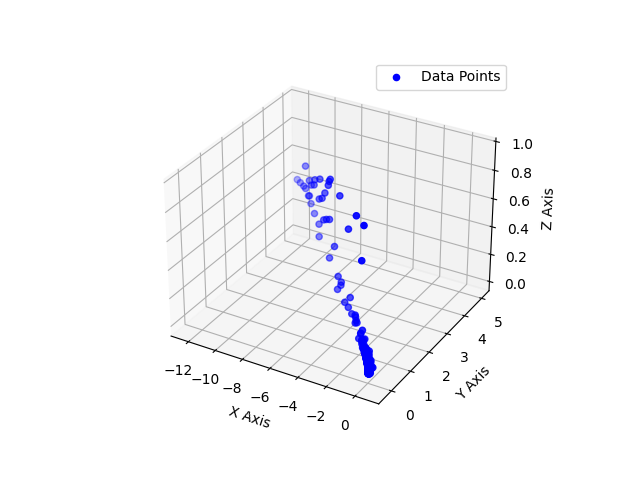

In [706]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.scatter( grad_wind, grad_temp,np.asarray(class_prob)[:,0], c='b', marker='o', label='Data Points')

# Plot the curves
# ax.plot(x, y, z, label='Curve 1', color='r')
# ax.plot(curve_x, curve_y2, curve_z, label='Curve 2', color='g')

# Set labels and legend
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.legend()

# Show the plot
plt.show()

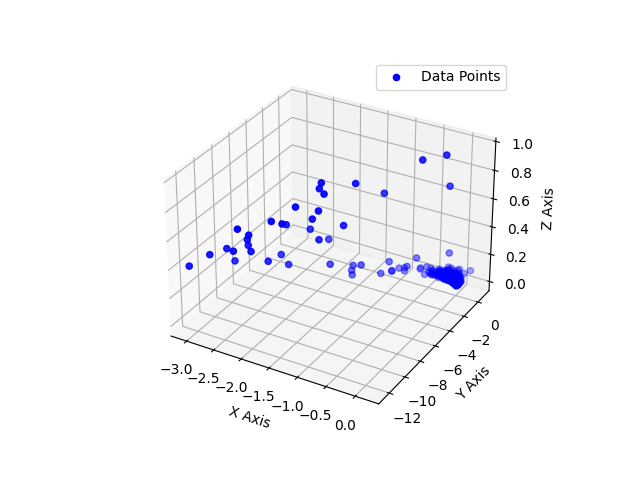

In [707]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.scatter( grad_precip, grad_wind,np.asarray(class_prob)[:,0], c='b', marker='o', label='Data Points')

# Plot the curves
# ax.plot(x, y, z, label='Curve 1', color='r')
# ax.plot(curve_x, curve_y2, curve_z, label='Curve 2', color='g')

# Set labels and legend
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.legend()

# Show the plot
plt.show()


In [727]:
# year_choice=2021
years_tot=np.arange(2000,2023,1)

# data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_unscaled,24,feature_choice)
data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,[0,1,2])

year_pick=int(year_choice-year_data_start)


pick_years=[year_pick]
for reg in range(1,len(reg_filt)):
    pick_years.append(year_pick+nb_years_tot*reg)

test_year_data=data_matrix2[pick_years]

test_year_data.shape

(17, 365, 3)

In [728]:
# print(np.whzere(

Heatmap Shape: (1, 365)


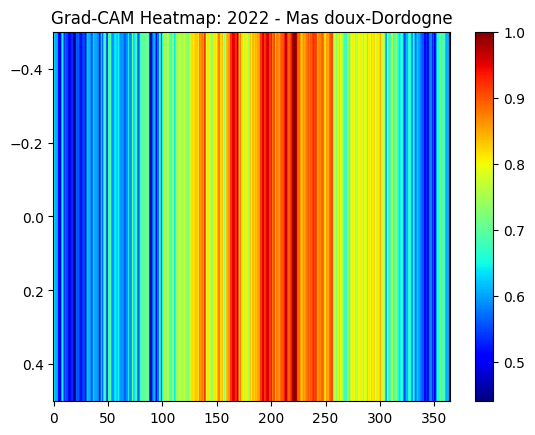

In [729]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model,Model
%matplotlib inline
# from lime.lime_tabular import LimeTabularExplainer
# import shap

# Load your pre-trained CNN model
model = load_model('Test_weights/'+ str(culture_num)+'_best_model_'+str(portion*100)+'.h5')
# Define the function to compute Grad-CAM
def grad_cam(model, input_data, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(input_data)

        conv_outputs, predictions = grad_model(input_data)
        loss = predictions[:, tf.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

example=1


# Choose a sample instance for explanation
# sample_idx = 0
test_data= test_year_data[example]

# Explain the prediction using LIME

# explainer = LimeTabularExplainer(test_data, mode="classification")

# Prepare your test data and convert it to the required format

test_data = test_year_data[example] # Replace with your actual test data
# test_data_reshaped = test_data.reshape(365,3)

# explanation = explainer.explain_instance(test_data, model.predict)
# Reshape the test data to match the model's input shape (if necessary)
test_data = np.expand_dims(test_data, axis=0)  # Uncomment if the model expects a single example
test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)  # Convert to TensorFlow tensor

# Compute Grad-CAM for the last convolutional layer
# layer_name = 'first_conv_layer'  # Replace with the name of the last convolutional laye
# layer_name = 'second_conv_layer'  # Replace with the name of the last convolutional laye
layer_name = 'last_conv_layer'  # Replace with the name of the last convolutional layer

heatmap = grad_cam(model, test_data, layer_name)

# Print the heatmap shape
print("Heatmap Shape:", heatmap.shape)

# Now you can visualize or analyze the heatmap as needed.
# You may plot it, overlay it on the original input data, etc.
# For example, to visualize the heatmap for the first example in the test data:
import matplotlib.pyplot as plt

plt.imshow(heatmap, interpolation ='none', aspect = 'auto',cmap='jet')
plt.title("Grad-CAM Heatmap: "+str(year_choice)+ ' - '+str(culture_name)+'-'+ str(reg_names[reg_filt[example]]) )
plt.colorbar()
plt.show()

In [651]:
# from datetime import datetime, timedelta

# bands=heatmap_analysis(heatmap,0.9)

# for day_iter in range(len(bands)):
                      
#     date_format = get_date(year_choice, int(bands[day_iter]+1))
#     print(f"{date_format[0]}/{date_format[1]}/{date_format[2]}")


In [730]:
heatmap

array([[0.537246  , 0.632094  , 0.6065465 , 0.6042564 , 0.6017666 ,
        0.5027253 , 0.49483895, 0.5916312 , 0.6448441 , 0.5899805 ,
        0.5337681 , 0.5610209 , 0.55065966, 0.5436388 , 0.5161161 ,
        0.49402076, 0.50831246, 0.53316873, 0.48934123, 0.44077307,
        0.5001199 , 0.5605412 , 0.55561095, 0.5619452 , 0.5358394 ,
        0.5206321 , 0.5067142 , 0.545827  , 0.54932994, 0.51711524,
        0.5705154 , 0.626369  , 0.6131191 , 0.61225647, 0.5870403 ,
        0.56201804, 0.57573223, 0.6279262 , 0.6074019 , 0.6042234 ,
        0.5872603 , 0.5836914 , 0.5143745 , 0.5628748 , 0.6263693 ,
        0.5663393 , 0.6300466 , 0.6765609 , 0.65650016, 0.56614923,
        0.53707874, 0.676432  , 0.6951237 , 0.6121282 , 0.5930222 ,
        0.5971787 , 0.62874174, 0.64399886, 0.62679386, 0.62471676,
        0.6461975 , 0.61331415, 0.5929583 , 0.5976554 , 0.5880158 ,
        0.56483746, 0.5668239 , 0.59135485, 0.5942593 , 0.6417963 ,
        0.58637834, 0.5849595 , 0.6012319 , 0.70

In [731]:

import matplotlib.pyplot as plt 
%matplotlib widget
x=[]
y=[]
z=[]
a=[]
b=[]
c=[]

xreal=[]
yreal=[]
zreal=[]
areal=[]
breal=[]
creal=[]

# feature_choice=[0,]
culture_times=[]
# year_choice=2018
years_tot=np.arange(2000,2023,1)

for year_choice in years_tot:
    # for i in range(len(reg_filt)):

    data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,[0,1,2])
    # data_matrix2=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_init,24,feature_choice)

    year_pick=int(year_choice-year_data_start)
    data_matrix3=region_year_filter(reg_filt,years_tot,nb_years_tot,data_matrix_unscaled,24,[0,1,2])

    pick_years=[year_pick]
    for reg in range(1,len(reg_filt)):
        pick_years.append(year_pick+nb_years_tot*reg)

    test_year_data=data_matrix2[pick_years]
    test_year_data2=data_matrix3[pick_years]
    # for ref
    for i in range(len(reg_filt)):
    # for year_choice in years_tot:

        idx_reg=reg_filt[i]
        # print(reg_names[reg_filt[i]])
        # print(reg_rep[i])
        # Prepare your test data and convert it to the required format
        test_data = test_year_data[i] # Replace with your actual test data
        
        # Reshape the test data to match the model's input shape (if necessary)
        test_data = np.expand_dims(test_data, axis=0)  # Uncomment if the model expects a single example
        test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)  # Convert to TensorFlow tensor

        # Compute Grad-CAM for the last convolutional layer
        # layer_name = 'first_conv_layer'  # Replace with the name of the last convolutional laye
        # layer_name = 'second_conv_layer'  # Replace with the name of the last convolutional laye
        layer_name = 'last_conv_layer'  # Replace with the name of the last convolutional layer

        heatmap = grad_cam(model, test_data, layer_name)

        bands=heatmap_analysis(heatmap,0.8)

        xreal.append(np.asarray(test_year_data2[i, bands,0]))
        yreal.append(np.asarray(test_year_data2[i, bands,1]))
        zreal.append(np.asarray(test_year_data2[i, bands,2]))
        areal.append(np.asarray(test_year_data2[i,:,0]))
        breal.append(np.asarray(test_year_data2[i, :,1]))
        creal.append(np.asarray(test_year_data2[i, :,2]))
        
        # xreal.append(unscaler(np.asarray(test_year_data[i, bands,0]),feature_choice,0,regs_min,regs_max))
        # yreal.append(unscaler(np.asarray(test_year_data[i, bands,1]),feature_choice,1,regs_min,regs_max))
        # zreal.append(unscaler(np.asarray(test_year_data[i, bands,2]),feature_choice,2,regs_min,regs_max))
        # areal.append(unscaler(np.asarray(test_year_data[i, bands,0]),feature_choice,0,regs_min,regs_max))
        # breal.append(unscaler(np.asarray(test_year_data[i, bands,1]),feature_choice,1,regs_min,regs_max))
        # creal.append(unscaler(np.asarray(test_year_data[i, bands,2]),feature_choice,2,regs_min,regs_max))      
        
        x.append(np.asarray(test_year_data[i,bands,0]))
        y.append(np.asarray(test_year_data[i, bands,1]))
        z.append(np.asarray(test_year_data[i,bands,2]))
        a.append(test_year_data[i,:,0])
        b.append(test_year_data[i,:,1])
        c.append(test_year_data[i,:,2])

        culture_times.append(np.asarray(bands))



x=np.asarray(np.hstack(x)).flatten()
y=np.asarray(np.hstack(y)).flatten()
z=np.asarray(np.hstack(z)).flatten()
a=np.asarray(np.hstack(a)).flatten()
b=np.asarray(np.hstack(b)).flatten()
c=np.asarray(np.hstack(c)).flatten()
a=np.delete(a,bands)
b=np.delete(b,bands)
c=np.delete(c,bands)


xreal=np.asarray(np.hstack(xreal)).flatten()
yreal=np.asarray(np.hstack(yreal)).flatten()
zreal=np.asarray(np.hstack(zreal)).flatten()
areal=np.asarray(np.hstack(areal)).flatten()
breal=np.asarray(np.hstack(breal)).flatten()
creal=np.asarray(np.hstack(creal)).flatten()
areal=np.delete(areal,bands)
breal=np.delete(breal,bands)
creal=np.delete(creal,bands)

# # Create figure and 3D axes
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Create the scatter plot
# ax.scatter(x, y, z, c='b', marker='o', label='in')
# # ax = fig.add_subplot(111, projection='3d')
# # Plot the curves
# # ax.scatter(a, b, c,c='g', label='out')
# # ax.plot(curve_x, curve_y2, curve_z, label='Curve 2', color='g')

# # Set labels and legend
# ax.set_xlabel('vitesse vent')
# ax.set_ylabel('température')
# ax.set_zlabel('précipitaition')
# ax.legend()

# # Show the plot
# plt.show()

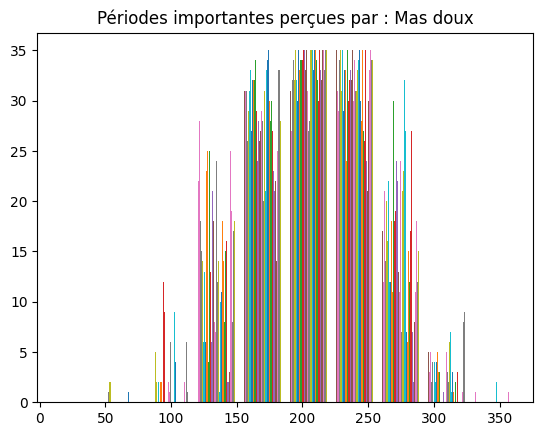

In [732]:
%matplotlib inline
plt.hist(culture_times)
plt.title('Périodes importantes perçues par : '+ str(culture_name))

plt.show()

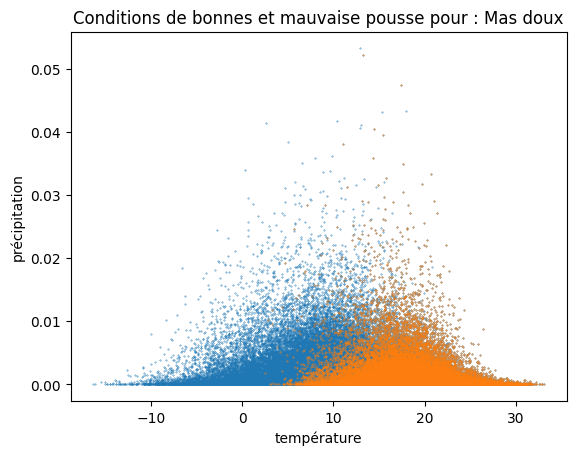

In [733]:
%matplotlib inline


plt.scatter(breal-273,creal,s=0.1,label='out')
plt.scatter(yreal-273,zreal,s=0.1,label='in')
plt.xlabel('température')
plt.ylabel('précipitation')
plt.title('Conditions de bonnes et mauvaise pousse pour : '+ str(culture_name))
plt.show()
# %matplotlib widget

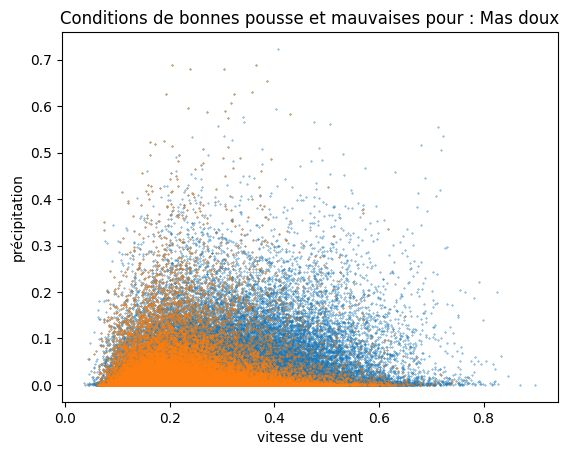

In [734]:
%matplotlib inline


plt.scatter(a,c,s=0.1,label='out')
plt.scatter(x,z,s=0.1,label='in')
plt.xlabel('vitesse du vent')
plt.ylabel('précipitation')
plt.title('Conditions de bonnes pousse et mauvaises pour : '+ str(culture_name))
plt.show()
# %matplotlib widget

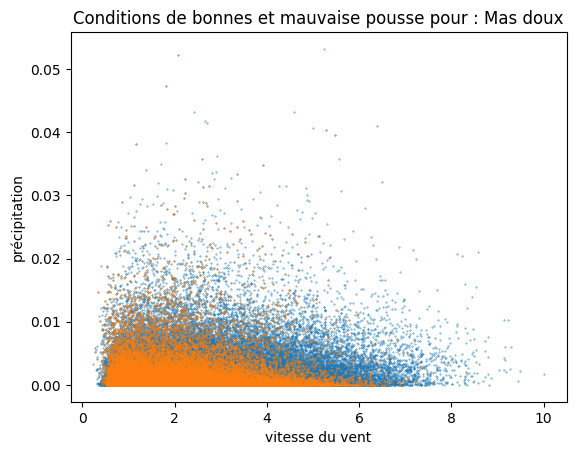

In [735]:
%matplotlib inline


plt.scatter(areal,creal,s=0.1,label='out')
plt.scatter(xreal,zreal,s=0.1,label='in')
plt.xlabel('vitesse du vent')
plt.ylabel('précipitation')
plt.title('Conditions de bonnes et mauvaise pousse pour : '+ str(culture_name))
plt.show()
# %matplotlib widget

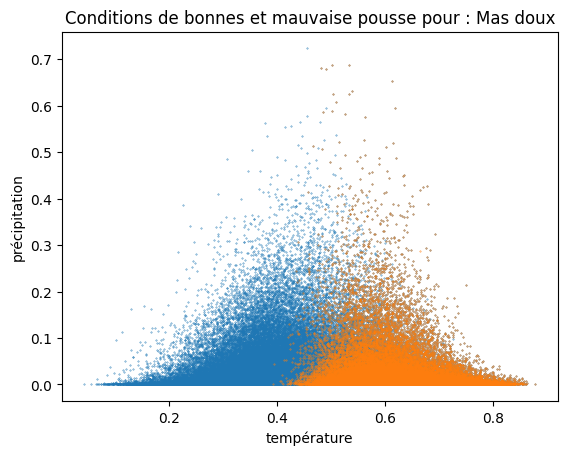

In [736]:
%matplotlib inline


plt.scatter(b,c,s=0.1,label='out')
plt.scatter(y,z,s=0.1,label='in')
plt.xlabel('température')
plt.ylabel('précipitation')
plt.title('Conditions de bonnes et mauvaise pousse pour : '+ str(culture_name))
plt.show()
# %matplotlib widget

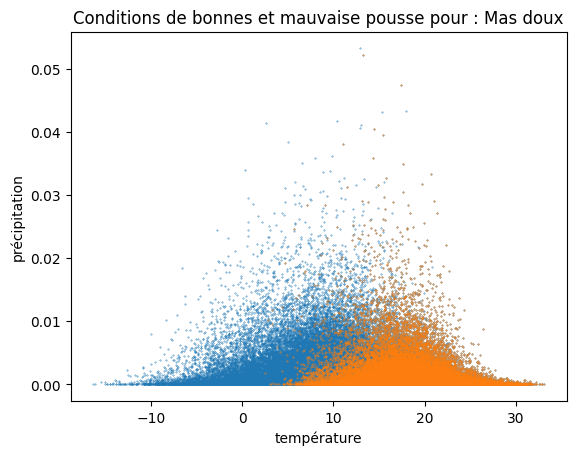

In [737]:
%matplotlib inline


plt.scatter(breal-273,creal,s=0.1,label='out')
plt.scatter(yreal-273,zreal,s=0.1,label='in')
plt.xlabel('température')
plt.ylabel('précipitation')
plt.title('Conditions de bonnes et mauvaise pousse pour : '+ str(culture_name))
plt.show()
# %matplotlib widget

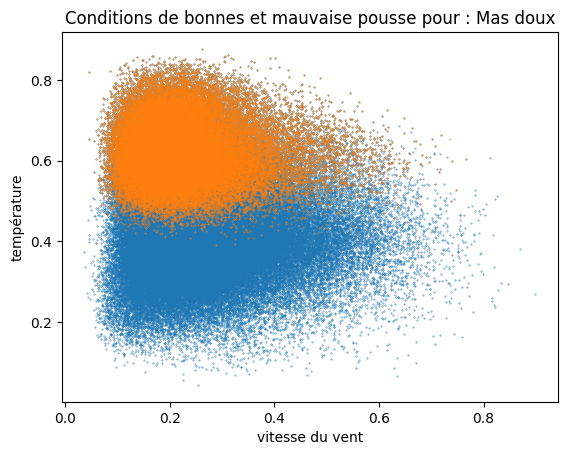

In [738]:
%matplotlib inline


plt.scatter(a,b,s=0.1,label='out')
plt.scatter(x,y,s=0.1,label='in')
plt.xlabel('vitesse du vent')
plt.ylabel('température')
plt.title('Conditions de bonnes et mauvaise pousse pour : '+ str(culture_name))
plt.show()
# %matplotlib widget

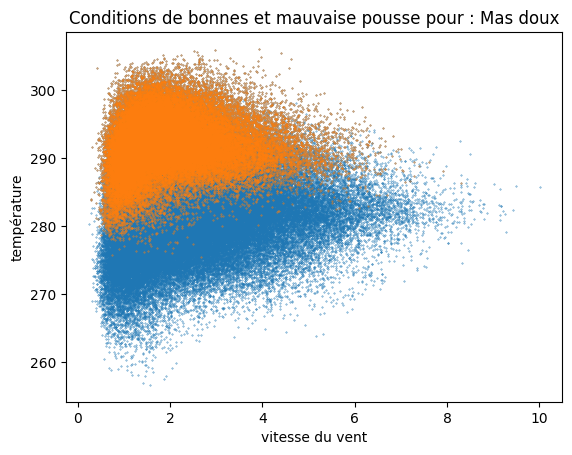

In [739]:
%matplotlib inline


plt.scatter(areal,breal,s=0.1,label='out')
plt.scatter(xreal,yreal,s=0.1,label='in')
plt.xlabel('vitesse du vent')
plt.ylabel('température')
plt.title('Conditions de bonnes et mauvaise pousse pour : '+ str(culture_name))
plt.show()
# %matplotlib widget

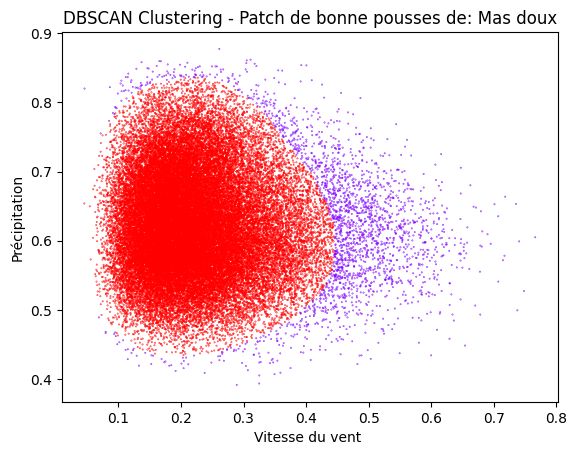

In [740]:
from sklearn.cluster import DBSCAN
epsilon = 0.04  # Adjust this value based on your dataset
min_samples = 800  #
data = np.column_stack((x, y))

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
labels = dbscan.fit_predict(data)
# Create a scatter plot of the data points, color-coded by their cluster labels

plt.scatter(x,y, c=labels, cmap='rainbow', s=0.1)
plt.xlabel('Vitesse du vent ')
plt.ylabel('Précipitation')
plt.title('DBSCAN Clustering - Patch de bonne pousses de: '+str(culture_name))
plt.show()

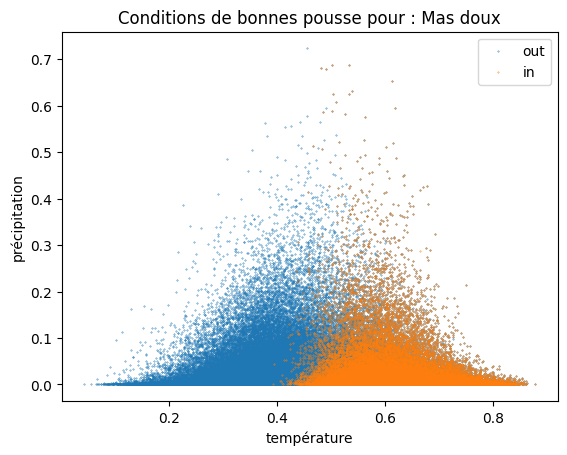

In [741]:
%matplotlib inline
plt.scatter(b,c,s=0.1,label='out')
plt.scatter(y,z,s=0.1,label='in')
plt.xlabel('température')
plt.ylabel('précipitation')
plt.title('Conditions de bonnes pousse pour : '+ str(culture_name))
plt.legend()
# %matplotlib widget

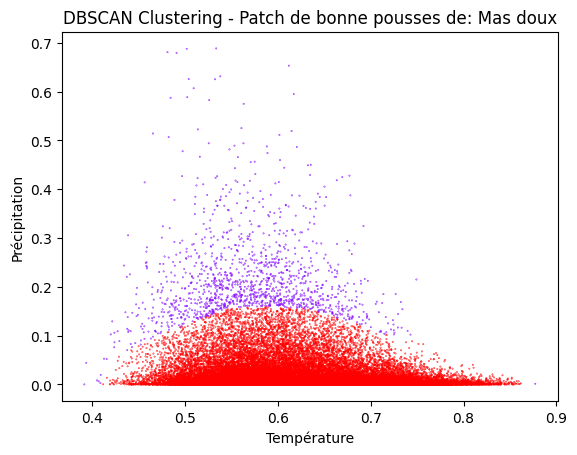

In [742]:
from sklearn.cluster import DBSCAN
epsilon = 0.04  # Adjust this value based on your dataset
min_samples = 800  #
data = np.column_stack((y, z))

dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
labels = dbscan.fit_predict(data)
# Create a scatter plot of the data points, color-coded by their cluster labels

plt.scatter(y, z, c=labels, cmap='rainbow', s=0.1)
plt.xlabel('Température')
plt.ylabel('Précipitation')
plt.title('DBSCAN Clustering - Patch de bonne pousses de: '+str(culture_name))
plt.show()

In [665]:



def unscaler(scaled_value,data_features,data_feature_idx,regs_min,regs_max)
    
    for reg in reg_filt:

    # Define the initial range of the data
        min_original = reg_mins[reg*len(data_features)+data_feature_idx]  # Minimum value of the original range
        max_original = reg_maxs[reg*len(data_features)+data_feature_idx]  # Maximum value of the original range        
        
        unscaled_value = scaled_value * (max_original - min_original) + min_original

    return unscaled_value

    


SyntaxError: invalid syntax (1369809866.py, line 1)

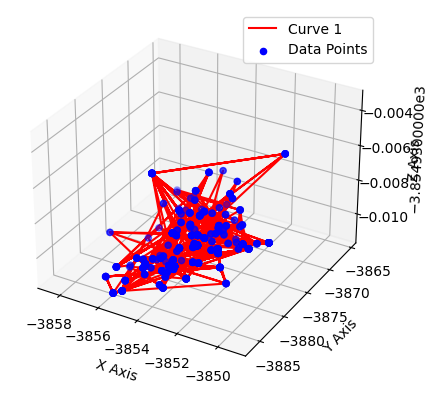

In [ ]:
x=[]
y=[]
z=[]
%matplotlib inline
for i in range(len(reg_filt)):
    
    # Prepare your test data and convert it to the required format
    test_data = test_year_data[i] # Replace with your actual test data

    # Reshape the test data to match the model's input shape (if necessary)
    test_data = np.expand_dims(test_data, axis=0)  # Uncomment if the model expects a single example
    test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)  # Convert to TensorFlow tensor

    # Compute Grad-CAM for the last convolutional layer
    layer_name = 'first_conv_layer'  # Replace with the name of the last convolutional laye
    # layer_name = 'second_conv_layer'  # Replace with the name of the last convolutional laye
    # layer_name = 'last_conv_layer'  # Replace with the name of the last convolutional layer

    heatmap = grad_cam(model, test_data, layer_name)

    bands=heatmap_analysis(heatmap,0.4)
    x.append(np.asarray(data_matrix_unscaled[year_pick*idx_reg, bands,0]))
    y.append(np.asarray(data_matrix_unscaled[year_pick*idx_reg, bands,1]-273.15))
    z.append(np.asarray(data_matrix_unscaled[year_pick*idx_reg, bands,2]))
    
    
x=np.asarray(np.hstack(x)).flatten()
y=np.asarray(np.hstack(y)).flatten()
z=np.asarray(np.hstack(z)).flatten()
# Create figure and 3D axes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
ax.scatter(x, y, z, c='b', marker='o', label='Data Points')

# Plot the curves
ax.plot(x, y, z, label='Curve 1', color='r')
# ax.plot(curve_x, curve_y2, curve_z, label='Curve 2', color='g')

# Set labels and legend
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.legend()

# Show the plot
plt.show()


In [ ]:
# #Génération des prédictions
prob_csv=[]
for portion in portions : 
        
        saved_model = load_model('Test_weights/'+str(culture_num)+'_best_model_'+str(portion*100)+'.h5')
        
        predictions=np.round(np.asarray(saved_model.predict(test_year_data))[:,1],2)
        prob_csv.append(predictions)

Columns=np.asarray(reg_rep)
prob_csv=pd.DataFrame(prob_csv,columns=Columns,index=portions)


3/3 [==============================] - 0s 13ms/step


23 59
Prédiction de la production la plus probable: 95.81%


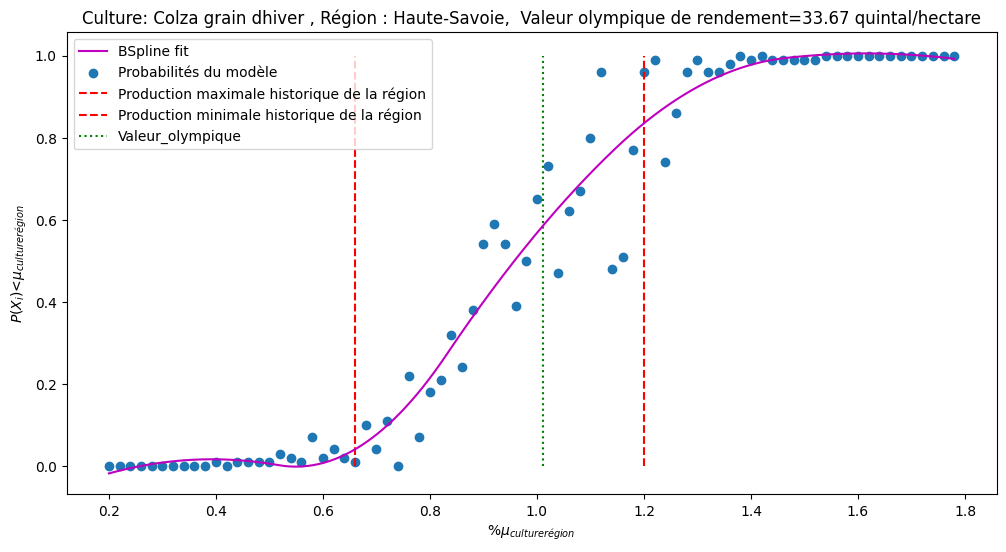

In [ ]:
import scipy.interpolate as interpolate
from scipy.interpolate import BSpline, splrep, splev


reg_filt_names=np.asarray(reg_names)[np.asarray(reg_filt).astype(int)]

N=20000
# 
choice=35
prob_region=np.asarray(prob_csv).T[choice] 

prob_region_cut,portions_cut=cut_prob2(prob_region,portions,x_min_region[choice],x_max_region[choice])

items_remove,smooth_curve=remove_outliers(prob_region_cut,portions_cut)

portions_out=np.delete(portions_cut,items_remove)
prob_region_out=np.delete(prob_region_cut,items_remove)

t, c, k = interpolate.splrep(portions, prob_region, s=0, k=4)


spline = interpolate.BSpline(t, c, k, extrapolate=False)

xmin, xmax =portions.min(), portions.max()
# xmin, xmax = portions_cut.min(), portions_cut.max()

xx = np.linspace(xmin, xmax, N)

n_interior_knots = 4
qs = np.linspace(0, 1, n_interior_knots+2)[1:-1]
knots = np.quantile(xx, qs)
tck = splrep(xx, spline(xx), t=knots, k=2)


ys_smooth = splev(xx, tck)

pred_likely=np.round(np.mean(xx[np.where(np.round(ys_smooth,2)==0.5)[0]])*100,2)

print('Prédiction de la production la plus probable: '+str(pred_likely)+'%')

# Display
plt.figure(figsize=(12, 6))
# plt.plot(xx, ys, '.c')
plt.plot(xx, ys_smooth, '-m',label='BSpline fit')
plt.scatter(portions,prob_region,label='Probabilités du modèle')

pred_olymp=np.where(ys_smooth==val_olymp_region[choice]*0.7)[0]

plt.ylabel(r'$P(X_{i})$<$\mu_{culture région}$')
plt.xlabel(r'$\%\mu_{culture région}$')
plt.title('Culture: '+str(culture_name)+' , Région : '+  str(reg_filt_names[choice])+',  Valeur olympique de rendement='+str(np.round(olymp_abs[choice],2))+' quintal/hectare')

plt.vlines(x_max_region[choice],0,1,label='Production maximale historique de la région',colors='r',linestyles='dashed')
plt.vlines(x_min_region[choice],0,1,label='Production minimale historique de la région',colors='r',linestyles='dashed')
plt.vlines(val_olymp_region[choice],0,1,label='Valeur_olympique',colors='g',linestyles='dotted')

plt.legend()
plt.show()
# plt.plot(xx,spline(xx))

In [ ]:
prod_france_year_fit=[]
prod_france_year_model=[]
N=10000
for choice in range(len(np.asarray(prob_csv).T)):
    
    most_prob=[] 

    #####

    prob_region=np.asarray(prob_csv).T[choice] 

    items_remove,smooth_curve= remove_outliers(prob_region,portions)
    smooth_curve= remove_outliers2(prob_region,portions)
    
    ext_remove=[]
    ext_remove.append(np.where(np.round(prob_region,4)==0)[0])
    # ext_remove.append(np.where(np.round(prob_region,1)==0.5)[0])
    ext_remove.append(np.where(np.round(prob_region,4)==1)[0])
    ext_remove=np.hstack(ext_remove)
    prob_region2=np.delete(prob_region,ext_remove)
    portions2=np.delete(portions,ext_remove)

    t, c, k = interpolate.splrep(portions, prob_region, s=0, k=4)
    # t, c, k = interpolate.splrep(portions, smooth_curve, s=0, k=4)
    # t, c, k = interpolate.splrep(portions2, prob_region2, s=0, k=4)

    spline = interpolate.BSpline(t, c, k, extrapolate=False)
        
    xmin, xmax =portions.min(), portions.max()
    # xmin, xmax =portions2.min() ,portions2.max()

    xx = np.linspace(xmin, xmax, N)

    n_interior_knots = 5
    
    qs = np.linspace(0, 1, n_interior_knots+2)[1:-1]
    knots = np.quantile(xx, qs)
    tck = splrep(xx, spline(xx), t=knots, k=2)
    ys_smooth = splev(xx, tck)
  
    prediction_rendement=np.nanmean(xx[np.where(np.round(ys_smooth,1)==0.5)[0]])*mean_regions[choice]
    prediction_rendement_model=np.mean(xx[np.where(np.round(spline(xx),4)==0.5)[0]])*mean_regions[choice]

    
    prod_france_year_fit.append(prediction_rendement)
    prod_france_year_model.append(prediction_rendement_model)
    
print('Prédiction smooth_Bspline du rendement moyen :', np.round(np.nanmean(prod_france_year_fit),1), 'quintals/h')
print('Prédiction Bspline du rendement moyen:', np.round(np.nanmean(prod_france_year_model),1), 'quintals/h')


Prédiction smooth_Bspline du rendement moyen : 29.2 quintals/h
Prédiction Bspline du rendement moyen: 28.8 quintals/h


In [ ]:
mean_rms,std_rms,min_rms,max_rms,rms,rms_noabs=rms_prod_model(prod_france_year_fit,rendement,year_choice)

# print(culture_name)
print('Delta moyen absolu prédiction modèle/réalité : ', mean_rms)
print('Delta écart type absolu entre prédiction modèle/réalité : ',std_rms)
print('Delta minimum absolu entre prédiction modèle/réalité : ',min_rms)
print('Delta max absolu entre prédiction modèle/réalité : ',max_rms)

Delta moyen absolu prédiction modèle/réalité :  2.3004339690126643
Delta écart type absolu entre prédiction modèle/réalité :  1.8656617139587368
Delta minimum absolu entre prédiction modèle/réalité :  0.00015464403583820285
Delta max absolu entre prédiction modèle/réalité :  7.330271427142719


Text(0, 0.5, 'Occurences')

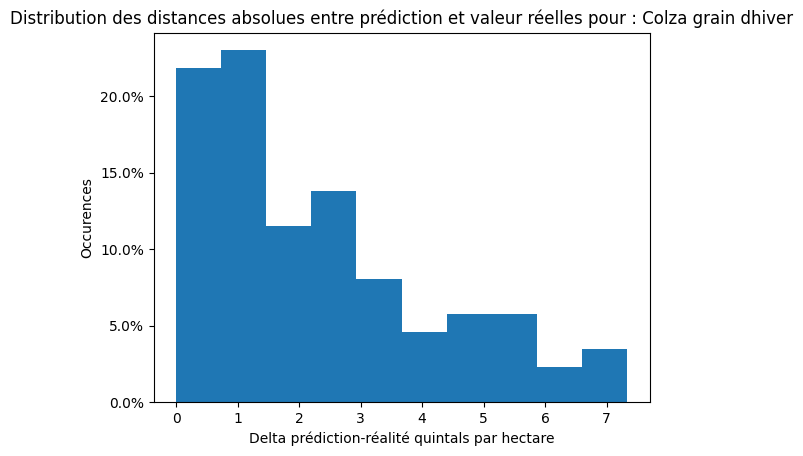

In [ ]:
from matplotlib.ticker import PercentFormatter

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.hist(rms, weights=np.ones(len(rms)) / len(rms))
plt.title('Distribution des distances absolues entre prédiction et valeur réelles pour : '+str(culture_name))
plt.xlabel('Delta prédiction-réalité quintals par hectare')
plt.ylabel('Occurences')

<AxesSubplot:ylabel='Density'>

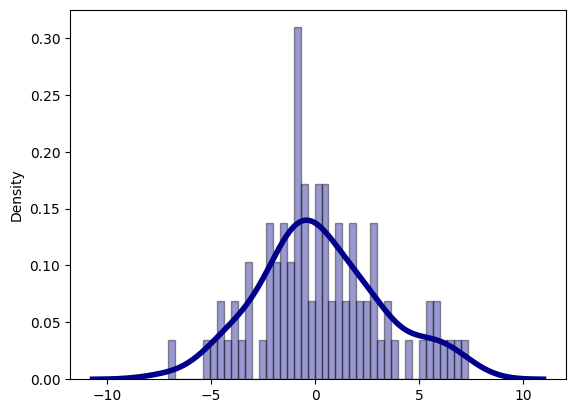

In [ ]:
import seaborn as sns

sns.distplot(rms_noabs,  hist=True, kde=True, 
             bins=int(len(rms)/2), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})


In [ ]:

score70,score80=accuracy_prod_assur(prod_france_year_fit,rendement,year_choice)

print(score70,score80)

0.011494252873563218 0.09195402298850575


In [ ]:
# prod_france_year_model
prod_france_year_fit

[30.4069049762119,
 37.46163568737824,
 25.952849451611822,
 17.883730944523016,
 34.51540874087408,
 17.232363807809346,
 25.04670486096228,
 32.84233209511426,
 25.79759452135689,
 26.626047604760462,
 34.90232766133756,
 20.222038160958945,
 33.41776901499672,
 28.113208273208265,
 29.316361969530274,
 26.80537237057038,
 27.777914219993416,
 29.705763909724297,
 31.88054112077874,
 28.231159425466345,
 24.85903490349034,
 29.772307611713543,
 23.530667590568573,
 32.61327575614703,
 35.22345544078215,
 36.267214149986415,
 31.949894860914657,
 20.886930435900727,
 26.81740960762742,
 23.57060887041084,
 32.58225555888921,
 28.023082212983198,
 21.543734087694475,
 27.25558334881106,
 30.25620617299824,
 32.234912348377684,
 28.617997990275207,
 19.839995751956145,
 26.389269403130783,
 18.817407626476925,
 31.008205563413476,
 27.188015111034904,
 28.803084165559397,
 30.521248791545812,
 31.6608463227275,
 25.72952295229522,
 29.30274634606317,
 23.908494658989703,
 27.14772434386

In [ ]:

steps_olymp=np.arange(0.4,1,0.1)

val_probs=[]
for step in steps_olymp:
    idx_pred_olymp=np.where(np.round(xx,2)==np.round(val_olymp_region[choice]*step,2))[0]
    val_probs.append(np.round(np.mean(ys_smooth[idx_pred_olymp])*100,2))

val_probs

[0.77, 3.83, 6.39, 8.27, 18.84, 45.45]